# 飞桨常规赛：PALM眼底彩照中黄斑中央凹定位-11月第1名方案

# （1）比赛介绍

## 赛题介绍

榜首个人主页，戳[此处](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/335435)查看

PALM黄斑定位常规赛的重点是研究和发展与患者眼底照片黄斑结构定位相关的算法。该常规赛的目标是评估和比较在一个常见的视网膜眼底图像数据集上定位黄斑的自动算法。具体目的是预测黄斑中央凹在图像中的坐标值。

![](https://ai-studio-static-online.cdn.bcebos.com/caac4481a304405db9e5c4ce14497c029ed4ca5d06b6485cb4decd97cbbd136a)


中央凹是视网膜中辨色力、分辨力最敏锐的区域。以人为例，在视盘颞侧约3.5mm处，有一黄色小区，称黄斑，其中央的凹陷，就是中央凹。中央凹的准确定位可辅助医生完成糖尿病视网膜、黄斑变性等病变的诊断。


## 赛程赛制

（1）飞桨常规赛面向全社会公开报名，直至赛题下线；

（2）飞桨常规赛不设初赛、复赛，以当月每位参赛选手提交的最优成绩排名。每月竞赛周期为本月 1 日至本月最后 1 日；

（3）比赛期间选手每天最多可提交 5 次作品（预测结果+原始代码），系统自动选取最高成绩作为榜单记录；

（4）每个月 1-5 日公布上一个月总榜。当月排名前10 且通过代码复查的选手可获得由百度飞桨颁发的荣誉证书。对于初次上榜的参赛选手，还可额外获得1份特别礼包（1个飞桨周边奖品+ 100小时GPU算力卡）。工作人员将以邮件形式通知上一月排名前10的选手提交材料供代码复查，请各位参赛选手留意邮箱通知。特别提醒： 已获得过特别礼包的参赛选手，如果基于本赛题撰写新的studio项目并被评为精选，才可再次获得1份特别礼包；

（5） score超过0.04的第一位选手可额外获得大奖：小度在家；

（6） 鼓励选手报名多个主题的飞桨常规赛，以赛促学，全方面提升开发者的深度学习能力。




# （2）数据介绍
PALM病理性近视预测常规赛由中山大学中山眼科中心提供800张带黄斑中央凹坐标标注的眼底彩照供选手训练模型，另提供400张带标注数据供平台进行模型测试。

## 数据说明
本次常规赛提供的金标准由中山大学中山眼科中心的7名眼科医生手工进行标注，之后由另一位高级专家将它们融合为最终的标注结果。本比赛提供数据集对应的黄斑中央凹坐标信息存储在xlsx文件中，名为“Fovea_Location_train”，第一列对应眼底图像的文件名(包括扩展名“.jpg”)，第二列包含x坐标，第三列包含y坐标。
图

## 训练数据集
文件名称：Train
Train文件夹里有一个文件夹fundus_images和一个xlsx文件。

fundus_images文件夹内包含800张眼底彩照，分辨率为1444×1444，或2124×2056。命名形如H0001.jpg、P0001.jpg、N0001.jpg和V0001.jpg。
xlsx文件中包含800张眼底彩照对应的x、y坐标信息。
## 测试数据集
文件名称：PALM-Testing400-Images 文件夹里包含400张眼底彩照，命名形如T0001.jpg。

# （3）个人思路+个人方案亮点

## 自定义数据集读取图片和标签

```
class dataset(paddle.io.Dataset):
    def __init__(self,img_list,label_listx,label_listy,transform=None,transform2=None,mode='train'):

        self.image=img_list
        self.labelx=label_listx
        self.labely=label_listy
        self.mode=mode
        self.transform=transform
        self.transform2=transform2
    def load_img(self, image_path):

        img=cv2.imread(image_path,1)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        h,w,c=img.shape
        return img,h,w


    def __getitem__(self,index):
        img,h,w = self.load_img(self.image[index])
        labelx = self.labelx[index]
        labely = self.labely[index]
        img_size=img.shape

        if self.transform:
            if self.mode=='train':
                img, label = self.transform([img, [labelx,labely]])
            else:
                img, label = self.transform2([img, [labelx,labely]])
        
        
        label=np.array(label,dtype='float32')
        img=np.array(img,dtype='float32')/255.0
        return img,label

    def __len__(self):
        return len(self.image)
```

## 使用新的数据增强方法对数据进行增广

```

class py1(object):
    # 将输入图像调整为指定大小

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):

        image = data[0]    # 获取图片
        key_pts = data[1]  # 获取标签

        image_copy = np.copy(image)      
        key_pts_copy = np.copy(key_pts)

        h, w = image_copy.shape[:2]
        if key_pts_copy[0]<self.output_size:
            left=np.random.random()*key_pts_copy[0]
        elif w-key_pts_copy[0]<self.output_size:
            left=w-(w-key_pts_copy[0])*np.random.random()-self.output_size
        else:
            left=key_pts_copy[0]-self.output_size*np.random.random()                                    

        if key_pts_copy[1]<self.output_size:
            top=np.random.random()*key_pts_copy[1]
        elif h-key_pts_copy[1]<self.output_size:
            top=w-(h-key_pts_copy[1])*np.random.random()-self.output_size
        else:
            top=key_pts_copy[1]-self.output_size*np.random.random() 
        left=int(left)
        top=int(top)
        x=(key_pts_copy[0]-left)/self.output_size
        y=(key_pts_copy[1]-top)/self.output_size
        img=image_copy[top:top+self.output_size,left:left+self.output_size]

        return img, [x,y]

class py2(object):
    # 将输入图像调整为指定大小

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):

        image = data[0]    # 获取图片
        key_pts = data[1]  # 获取标签

        image_copy = np.copy(image)      
        key_pts_copy = np.copy(key_pts)

        h, w = image_copy.shape[:2]
        if key_pts_copy[0]<self.output_size/2:
            left=0
        elif w-key_pts_copy[0]<self.output_size/2:
            left=w-self.output_size
        else:
            left=key_pts_copy[0]-self.output_size/2                             

        if key_pts_copy[1]<self.output_size/2:
            top=0
        elif h-key_pts_copy[1]<self.output_size/2:
            top=w-self.output_size
        else:
            top=key_pts_copy[1]-self.output_size/2
        left=int(left)
        top=int(top)
        x=(key_pts_copy[0]-left)/self.output_size
        y=(key_pts_copy[1]-top)/self.output_size
        img=image_copy[top:top+self.output_size,left:left+self.output_size]

        return img, [x,y]



class GrayNormalize(object):
    # 将图片变为灰度图，并将其值放缩到[0, 1]
    # 将 label 放缩到 [-1, 1] 之间

    def __call__(self, data):
        image = data[0]   # 获取图片
        key_pts = data[1] # 获取标签
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # 灰度化图片
        gray_scale = paddle.vision.transforms.Grayscale(num_output_channels=3)
        image_copy = gray_scale(image_copy)
        
        ## 将图片值放缩到 [0, 1]
        #image_copy = (image_copy-127.5) /127.5
        
        # 将坐标点放缩到 [-1, 1]
        #mean = data_mean # 获取标签均值
        #std = data_std   # 获取标签标准差

        #key_pts_copy = (key_pts_copy - mean)/std

        return image_copy, key_pts_copy

class ToCHW(object):
    # 将图像的格式由HWC改为CHW
    def __call__(self, data):

        image = data[0]
        key_pts = data[1]

        transpose = T.Transpose((2, 0, 1)) # 改为CHW
        image = transpose(image)

        
        return image, key_pts
```



# （4）具体方案分享

代码参考：[『深度学习7日打卡营』人脸关键点检测](https://aistudio.baidu.com/aistudio/projectdetail/1487972)

## 解压数据集

In [1]:
!unzip -oq /home/aistudio/data/data116960/常规赛：PALM眼底彩照中黄斑中央凹定位.zip
!mv │г╣ц╚№г║PALM╤█╡╫▓╩╒╒╓╨╗╞░▀╓╨╤ы░╝╢и╬╗ 常规赛：PALM眼底彩照中黄斑中央凹定位 #不知道为什么会出现乱码，可用此代码恢复中文
!rm -rf __MACOSX

## 查看数据标签

In [1]:
import blackhole.dataframe as pd
df=pd.read_excel('常规赛：PALM眼底彩照中黄斑中央凹定位/Train/Fovea_Location_train.xlsx')
df.head()

,imgName,Fovea_X,Fovea_Y
0,H0001.jpg,743.96,790.54
1,H0002.jpg,1394.82,725.54
2,H0003.jpg,1361.74,870.72
3,H0004.jpg,703.15,742.44
4,H0005.jpg,1070.95,1037.54


## 数据增强

In [2]:
import paddle.vision.transforms.functional as F
class py1(object):
    # 将输入图像调整为指定大小

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):

        image = data[0]    # 获取图片
        key_pts = data[1]  # 获取标签

        image_copy = np.copy(image)      
        key_pts_copy = np.copy(key_pts)

        h, w = image_copy.shape[:2]
        if key_pts_copy[0]<self.output_size:
            left=np.random.random()*key_pts_copy[0]
        elif w-key_pts_copy[0]<self.output_size:
            left=w-(w-key_pts_copy[0])*np.random.random()-self.output_size
        else:
            left=key_pts_copy[0]-self.output_size*np.random.random()                                    

        if key_pts_copy[1]<self.output_size:
            top=np.random.random()*key_pts_copy[1]
        elif h-key_pts_copy[1]<self.output_size:
            top=w-(h-key_pts_copy[1])*np.random.random()-self.output_size
        else:
            top=key_pts_copy[1]-self.output_size*np.random.random() 
        left=int(left)
        top=int(top)
        x=(key_pts_copy[0]-left)/self.output_size
        y=(key_pts_copy[1]-top)/self.output_size
        img=image_copy[top:top+self.output_size,left:left+self.output_size]

        return img, [x,y]

class py2(object):
    # 将输入图像调整为指定大小

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, data):

        image = data[0]    # 获取图片
        key_pts = data[1]  # 获取标签

        image_copy = np.copy(image)      
        key_pts_copy = np.copy(key_pts)

        h, w = image_copy.shape[:2]
        if key_pts_copy[0]<self.output_size/2:
            left=0
        elif w-key_pts_copy[0]<self.output_size/2:
            left=w-self.output_size
        else:
            left=key_pts_copy[0]-self.output_size/2                             

        if key_pts_copy[1]<self.output_size/2:
            top=0
        elif h-key_pts_copy[1]<self.output_size/2:
            top=w-self.output_size
        else:
            top=key_pts_copy[1]-self.output_size/2
        left=int(left)
        top=int(top)
        x=(key_pts_copy[0]-left)/self.output_size
        y=(key_pts_copy[1]-top)/self.output_size
        img=image_copy[top:top+self.output_size,left:left+self.output_size]

        return img, [x,y]



class GrayNormalize(object):
    # 将图片变为灰度图，并将其值放缩到[0, 1]
    # 将 label 放缩到 [-1, 1] 之间

    def __call__(self, data):
        image = data[0]   # 获取图片
        key_pts = data[1] # 获取标签
        
        image_copy = np.copy(image)
        key_pts_copy = np.copy(key_pts)

        # 灰度化图片
        gray_scale = paddle.vision.transforms.Grayscale(num_output_channels=3)
        image_copy = gray_scale(image_copy)
        
        ## 将图片值放缩到 [0, 1]
        #image_copy = (image_copy-127.5) /127.5
        
        # 将坐标点放缩到 [-1, 1]
        #mean = data_mean # 获取标签均值
        #std = data_std   # 获取标签标准差

        #key_pts_copy = (key_pts_copy - mean)/std

        return image_copy, key_pts_copy

class ToCHW(object):
    # 将图像的格式由HWC改为CHW
    def __call__(self, data):

        image = data[0]
        key_pts = data[1]

        transpose = T.Transpose((2, 0, 1)) # 改为CHW
        image = transpose(image)

        
        return image, key_pts

In [3]:
import paddle.vision.transforms as T
data_transform = T.Compose([
                        py1(224),
                        
                        GrayNormalize(),
                        ToCHW(),

                         ])
data_transform2 = T.Compose([
                        py2(224),
                        GrayNormalize(),
                        ToCHW(),

                        ])

## 自定义数据集

In [4]:
path='常规赛：PALM眼底彩照中黄斑中央凹定位/Train/fundus_image/'
df=df.sample(frac=1)
image_list=[]
label_listx=[]
label_listy=[]

for i in range(len(df)):
        image_list.append(path+df['imgName'][i])
        label_listx.append(df['Fovea_X'][i])
        label_listy.append(df['Fovea_Y'][i])

In [5]:
import os
test_path='常规赛：PALM眼底彩照中黄斑中央凹定位/PALM-Testing400-Images'
test_list=[]
test_labelx=[]
test_labely=[]
#list=pd.read_csv('result54.70313.csv')
list=pd.read_csv('????.csv')   #????.csv为以前提交的结果文件，选一个成绩好的。

#list = os.listdir(test_path)  # 列出文件夹下所有的目录与文件
for i in range(0, len(list)):
    path = os.path.join(test_path, list['FileName'][i])
    test_list.append(path)
    test_labelx.append(list['Fovea_X'][i])
    test_labely.append(list['Fovea_Y'][i])

In [6]:
import paddle
import cv2
import numpy as np
class dataset(paddle.io.Dataset):
    def __init__(self,img_list,label_listx,label_listy,transform=None,transform2=None,mode='train'):

        self.image=img_list
        self.labelx=label_listx
        self.labely=label_listy
        self.mode=mode
        self.transform=transform
        self.transform2=transform2
    def load_img(self, image_path):

        img=cv2.imread(image_path,1)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        h,w,c=img.shape
        return img,h,w


    def __getitem__(self,index):
        img,h,w = self.load_img(self.image[index])
        labelx = self.labelx[index]
        labely = self.labely[index]
        img_size=img.shape

        if self.transform:
            if self.mode=='train':
                img, label = self.transform([img, [labelx,labely]])
            else:
                img, label = self.transform2([img, [labelx,labely]])
        
        
        label=np.array(label,dtype='float32')
        img=np.array(img,dtype='float32')/255.0
        return img,label

    def __len__(self):
        return len(self.image)

## 训练集、验证集、测试集

In [7]:
radio=0.8
train_list=image_list[:int(len(image_list)*radio)]
train_labelx=label_listx[:int(len(label_listx)*radio)]
train_labely=label_listy[:int(len(label_listy)*radio)]


val_list=image_list[int(len(image_list)*radio):]
val_labelx=label_listx[int(len(label_listx)*radio):]
val_labely=label_listy[int(len(label_listy)*radio):]


train_ds=dataset(train_list,train_labelx,train_labely,data_transform,data_transform2,'train')
val_ds=dataset(val_list,val_labelx,val_labely,data_transform,data_transform2,'valid')
test_ds=dataset(test_list,test_labelx,test_labely,data_transform,data_transform2,'test')

## 查看图片

(224, 224, 3)


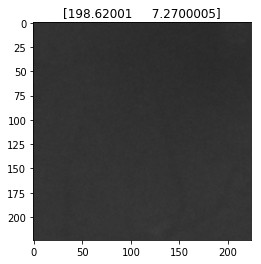

In [14]:
import matplotlib.pyplot as plt
for i,data in enumerate(train_ds):
    
    img,label=data

    img=img.transpose([1,2,0])
    print(img.shape)

    plt.title(label*224)
    plt.imshow(img)
    plt.show()

    if i==0:
        break

## 模型组网
以下两个网络结构任选一

In [15]:
class MyNet1(paddle.nn.Layer):
    def __init__(self,num_classes=2):
        super(MyNet1,self).__init__()
        self.net=paddle.vision.resnet152(pretrained=True)

        self.fc1=paddle.nn.Linear(1000,512)
        self.relu=paddle.nn.ReLU()
        self.fc2=paddle.nn.Linear(512,num_classes)

    def forward(self,inputs):
        out=self.net(inputs)

        out=self.fc1(out)
        out=self.relu(out)
        out=self.fc2(out)

        return out

In [17]:
class MyNet2(paddle.nn.Layer):
    def __init__(self):
        super(MyNet2, self).__init__()
        self.resnet = paddle.vision.resnet50(pretrained=True, num_classes=0) # remove final fc 输出为[?, 2048, 1, 1]
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(2048, 512)
        self.linear_2 = paddle.nn.Linear(512, 256)
        self.linear_3 = paddle.nn.Linear(256, 2)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
    
    def forward(self, inputs):

        y = self.resnet(inputs)
        y = self.flatten(y)
        y = self.linear_1(y)
        y = self.linear_2(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_3(y)
        y = paddle.nn.functional.sigmoid(y)

        return y

## 异步加载数据

In [18]:
train_loader = paddle.io.DataLoader(train_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=True, num_workers=0)
val_loader = paddle.io.DataLoader(val_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=False, num_workers=0)
test_loader=paddle.io.DataLoader(test_ds, places=paddle.CPUPlace(), batch_size=32, shuffle=False, num_workers=0)

## 自定义损失函数

In [19]:
from sklearn.metrics.pairwise import euclidean_distances 
import paddle.nn as nn

# 损失函数
def cal_coordinate_Loss(logit, label, alpha = 0.5):
    """
    logit: shape [batch, ndim]
    label: shape [batch, ndim]
    ndim = 2 represents coordinate_x and coordinaate_y
    alpha: weight for MSELoss and 1-alpha for ED loss
    return: combine MSELoss and ED Loss for x and y, shape [batch, 1]
    """
    alpha = alpha
    mse_loss = nn.MSELoss(reduction='mean')

    mse_x = mse_loss(logit[:,0],label[:,0])
    mse_y = mse_loss(logit[:,1],label[:,1])
    mse_l = 0.5*(mse_x + mse_y)
    # print('mse_l', mse_l)

    ed_loss = []
    # print(logit.shape[0])
    for i in range(logit.shape[0]):
        logit_tmp = logit[i,:].numpy()
        label_tmp = label[i,:].numpy()
        # print('cal_coordinate_loss_ed', logit_tmp, label_tmp)        
        ed_tmp = euclidean_distances([logit_tmp], [label_tmp])
        # print('ed_tmp:', ed_tmp[0][0])
        ed_loss.append(ed_tmp)
    
    ed_l = sum(ed_loss)/len(ed_loss)
    # print('ed_l', ed_l)
    # print('alpha', alpha)
    loss = alpha * mse_l + (1-alpha) * ed_l
    # print('loss in function', loss)
    return loss

In [20]:
class SelfDefineLoss(paddle.nn.Layer):
   """
   1. 继承paddle.nn.Layer
   """
   def __init__(self):
       """
       2. 构造函数根据自己的实际算法需求和使用需求进行参数定义即可
       """
       super(SelfDefineLoss, self).__init__()

   def forward(self, input, label):
       """
       3. 实现forward函数，forward在调用时会传递两个参数：input和label
           - input：单个或批次训练数据经过模型前向计算输出结果
           - label：单个或批次训练数据对应的标签数据
           接口返回值是一个Tensor，根据自定义的逻辑加和或计算均值后的损失
       """
       # 使用PaddlePaddle中相关API自定义的计算逻辑
       output = cal_coordinate_Loss(input,label)
       return output

## 模型训练与可视化

如果图片尺寸较大应适当调小Batch_size，防止爆显存。

In [22]:
from utils import NME
import warnings
warnings.filterwarnings('ignore')
visualdl=paddle.callbacks.VisualDL(log_dir='visual_log')

#定义输入

Batch_size=32
EPOCHS=20
step_each_epoch = len(train_ds)//Batch_size


# 使用 paddle.Model 封装模型
model = paddle.Model(MyNet2())

#模型加载
#model.load('/home/aistudio/work/lup/final')


lr = paddle.optimizer.lr.CosineAnnealingDecay(learning_rate=1e-5,
                                                T_max=step_each_epoch * EPOCHS)




# 定义Adam优化器
optimizer = paddle.optimizer.Adam(learning_rate=lr,
                                weight_decay=1e-5,
                                parameters=model.parameters())
# 定义SmoothL1Loss
loss =paddle.nn.SmoothL1Loss()
#loss =SelfDefineLoss()

# 使用自定义metrics
metric = NME()

model.prepare(optimizer=optimizer, loss=loss, metrics=metric)




# 训练可视化VisualDL工具的回调函数

# 启动模型全流程训练
model.fit(train_loader,  # 训练数据集
          val_loader,   # 评估数据集
          epochs=EPOCHS,       # 训练的总轮次
          batch_size=Batch_size,  # 训练使用的批大小
          save_dir="/home/aistudio/work/lup", #把模型参数、优化器参数保存至自定义的文件夹
          save_freq=1,                    #设定每隔多少个epoch保存模型参数及优化器参数
          verbose=1 ,      # 日志展示形式
          callbacks=[visualdl]
          )  # 设置可视化

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/20
step 20/20 [==============================] - loss: 0.0604 - nme: 0.4010 - 4s/step           
save checkpoint at /home/aistudio/work/lup/0
Eval begin...
step 5/5 [==============================] - loss: 0.0053 - nme: 0.1495 - 8s/step
Eval samples: 160
Epoch 2/20
step 20/20 [==============================] - loss: 0.0361 - nme: 0.3705 - 2s/step           
save checkpoint at /home/aistudio/work/lup/1
Eval begin...
step 5/5 [==============================] - loss: 0.0100 - nme: 0.1334 - 2s/step
Eval samples: 160
Epoch 3/20
step 20/20 [==============================] - loss: 0.0350 - nme: 0.3663 - 2s/step           
save checkpoint at /home/aistudio/work/lup/2
Eval begin...
step 5/5 [==============================] - loss: 0.0096 - nme: 0.1611 - 2s/step
Eval samples: 160
Epoch 4/20
step 20/20 [==============================] - loss: 0.0353 - nme: 0.3423 - 2s/step        

## 模型评估

In [23]:
# 模型评估
model.load('/home/aistudio/work/lup/5')
result = model.evaluate(val_loader, verbose=1)
print(result)

Eval begin...
step 5/5 [==============================] - loss: 0.0057 - nme: 0.1273 - 2s/step
Eval samples: 160
{'loss': [0.005723397], 'nme': 0.1273284799297331}


## 进行预测操作

In [24]:
# 进行预测操作
result = model.predict(test_loader)

Predict begin...
step 13/13 [==============================] - 2s/step          
Predict samples: 400


In [26]:
# 获取测试图片尺寸和图片名
test_path='常规赛：PALM眼底彩照中黄斑中央凹定位/PALM-Testing400-Images'
test_size=[]
FileName=[]
for i in range(len(list)):
    #path = os.path.join(test_path, list[i])
    path=test_list[i]
    img=cv2.imread(path,1)
    test_size.append(img.shape)
    FileName.append(list['FileName'][i])
test_size=np.array(test_size)

In [32]:
result=np.array(result)
pred=[]
for i in range(len(result[0])):
    pred.extend(result[0][i])
pred=np.array(pred) 

pred = paddle.to_tensor(pred)
out=np.array(pred).reshape(-1,2)

#Fovea_X=out[:,0]*data_std+data_mean
#Fovea_Y=out[:,1]*data_std+data_mean
Fovea_X=out[:,0]
Fovea_Y=out[:,1]

#Fovea_X=Fovea_X*test_size[:,1]
#Fovea_Y=Fovea_Y*test_size[:,0]
for i in range(400):
    if test_labelx[i]<112:
        x0=0
    elif test_labelx[i]>(test_size[i][1]-112):
        x0=test_size[i][1]-112
    else:
        x0=test_labelx[i]-112

    if test_labely[i]<112:
        y0=0
    elif test_labely[i]>test_size[i][0]-112:
        y0=test_size[i][0]-112
    else:
        y0=test_labely[i]-112


    Fovea_X[i]=x0+Fovea_X[i]*224
    Fovea_Y[i]=y0+Fovea_Y[i]*224

submission = pd.DataFrame(data={
                            "FileName": FileName,
                            "Fovea_X": Fovea_X,
                            "Fovea_Y": Fovea_Y
                        })
submission=submission.sort_values(by='FileName')
submission.to_csv("result.csv", index=False)

## 结果文件查看

In [33]:
submission.head()

,FileName,Fovea_X,Fovea_Y
0,T0001.jpg,1275.212769,947.638123
1,T0002.jpg,1078.371338,1054.087524
2,T0003.jpg,1079.881104,1059.292847
3,T0004.jpg,1302.749023,1016.598938
4,T0005.jpg,1309.635010,701.692017


## 结果投票集成

简单投票集成学习，这个可以提升效果，尽量选得分高的进行投票。

在统计学和机器学习中，集成学习方法使用多种学习算法来获得比单独使用任何单独的学习算法更好的预测性能。

使用不同超参数、不同的特征，不同的结构，运行多次模型可得到不同的预测结果。在这里我使用的是简单投票法，取平均值作为最终的预测结果。 预测出多个result后，进行投票，代码如下：

In [ ]:
import numpy as np
import blackhole.dataframe as pd
df1=pd.read_csv('result40.14874.csv')
df2=pd.read_csv('result41.98309.csv')
df3=pd.read_csv('result54.70313.csv')
df4=pd.read_csv('result49.75246.csv')


dfs=[df1,df2,df3,df4]

File_Name=[]
Fovea_X=[]
Fovea_Y=[]
for i in range(len(df1)):
    File_Name.append(dfs[0]['FileName'][i])
    avgx=(sum(np.array(dfs[x]['Fovea_X'][i]) for x in range(len(dfs))))/len(dfs)
    avgy=(sum(np.array(dfs[x]['Fovea_Y'][i]) for x in range(len(dfs))))/len(dfs)
    
    Fovea_X.append(avgx)
    Fovea_Y.append(avgy)
submission = pd.DataFrame(data={
                            "FileName": File_Name,
                            "Fovea_X": Fovea_X,
                            "Fovea_Y":Fovea_Y
                        })
submission=submission.sort_values(by='FileName')
submission.to_csv("result.csv", index=False)

# （5）总结及改善方向

1、多试几个的预训练模型。

2、选择合适的学习率。

3、更换别的优化器。

4、投票方法能提高成绩，但是存在天花板。

5、曾专门用训练神经网络对中央凹可见、不可见情况进行了分类，结果测试集并未分到中央凹不可见的类别，但是总觉得测试集定位应该有（0，0），不是很确定。

# （6）飞桨使用体验+给其他选手学习飞桨的建议

建议大家多参加百度AI Studio课程，多看别人写的AI Studio项目，也许会有灵感迸发，在比赛中取得更好的成绩。

# （7）One More Thing

眼底彩照中黄斑中央凹定位相关论文

1.[Pathological myopia classification with simultaneous lesion segmentation using deep learning](https://www.sciencedirect.com/science/article/pii/S0169260720317533)

2.[Detection of Pathological Myopia and Optic Disc Segmentation with Deep Convolutional Neural Networks](https://ieeexplore.ieee.org/abstract/document/8929252/)

[我在AI Studio上获得钻石等级，点亮10个徽章，来互关呀~](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/335435)
